In [1]:
import numpy as np
import matplotlib.pyplot as plt

$$\frac{dh}{dt} + H \left( \frac{du}{dx} + \frac{dv}{dy} \right) = 0$$
$$\frac{du}{dt} - fv = - g \frac{dh}{dx}$$
$$\frac{dv}{dt} + fu = - g \frac{dh}{dy}$$

$$\frac{h_{x, y}^{t+1} - h_{x, y}^{t}}{\Delta t} = - H \left( \frac{u_{x + \frac{1}{2}, y}^{t} - u_{x - \frac{1}{2}, y}^{t}}{\Delta x} + \frac{v_{x, y + \frac{1}{2}}^{t} - v_{x, y - \frac{1}{2}}^{t}}{\Delta t} \right)$$
$$ \frac{u_{x + \frac{1}{2}, y}^{t+1} - u_{x + \frac{1}{2}, y}^{t}}{\Delta t} = f v_{x + \frac{1}{2}, y}^{t} - g \frac{h_{x + 1, y}^{t} - h_{x, y}^{t}}{\Delta x}$$
$$\frac{v_{x, y + \frac{1}{2}}^{t+1} - v_{x, y + \frac{1}{2}}^t}{\Delta t} = - f u_{x, y + \frac{1}{2}}^{t} - g \frac{h_{x, y+1}^{t} - h_{x, y}^t}{\Delta y}$$

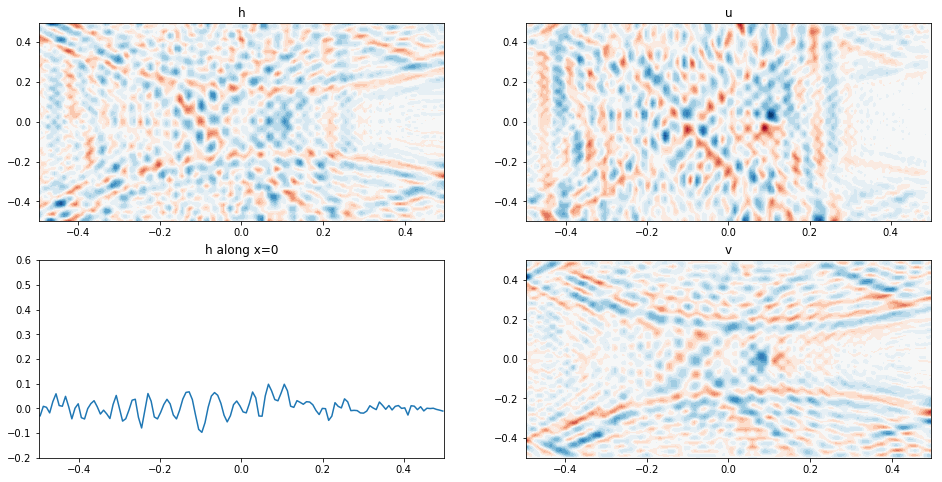

In [2]:
import numpy as np
import matplotlib.pyplot as plt

plot_interval = 200          # plot every n steps

## CONFIGURATION
### Assign constant values
nx = 128
ny = 129

H  = 100.0          # [m]  average height
Lx = 2.0e7          # [m]  width of domain
Ly = 1.0e7          # [m]  height of domain

f = 1.0e-5          # coriolis coefficient
g = 1.0             # acceleration due to gravity

dt = 100.0
dx = Lx / nx
dy = Ly / ny

## GRID
# Setup the Arakawa-C Grid:
#
# +-- v --+
# |       |    * (nx, ny)   h points at grid centres
# u   h   u    * (nx+1, ny) u points on vertical edges  (u[0] and u[nx] are boundary values)
# |       |    * (nx, ny+1) v points on horizontal edges
# +-- v --+
#
# Variables preceeded with underscore  (_u, _v, _h) include the boundary values,
# variables without (u, v, h) are a view onto only the values defined
# within the domain
_u = np.zeros((nx+3, ny+2))
_v = np.zeros((nx+2, ny+3))
_h = np.zeros((nx+2, ny+2))

u = _u[1:-1, 1:-1]               # (nx+1, ny)
v = _v[1:-1, 1:-1]               # (nx, ny+1)
h = _h[1:-1, 1:-1]               # (nx, ny)

state = np.array([u, v, h])

# positions of the value points in [m]
ux = (-Lx/2 + np.arange(nx+1)*dx)[:, np.newaxis]
vx = (-Lx/2 + dx/2.0 + np.arange(nx)*dx)[:, np.newaxis]

vy = (-Ly/2 + np.arange(ny+1)*dy)[np.newaxis, :]
uy = (-Ly/2 + dy/2.0 + np.arange(ny)*dy)[np.newaxis, :]

hx = vx
hy = uy

t = 0.0

def update_boundaries():
    # Solid walls on boundary
    #    - No zonal (u) flow through the walls
    #    - Zero x-derivative in h
    _u[:1, :] = 0
    _u[-2:, :] = 0
    _u[:, 0] = 0
    _u[:, -1] = 0

    _v[:, :1] = 0
    _v[:, -2:] = 0
    _v[0, :] = 0
    _v[-1, :] = 0
    
    _h[0, :] = _h[1, :]
    _h[-1, :] = _h[-2, :]
    _h[:, 0] = _h[:, 1]
    _h[:, -1] = _h[:, -2]

    for field in state:
        # fix corners to be average of neighbours
        field[0, 0] =  0.5*(field[1, 0] + field[0, 1])
        field[-1, 0] = 0.5*(field[-2, 0] + field[-1, 1])
        field[0, -1] = 0.5*(field[1, -1] + field[0, -2])
        field[-1, -1] = 0.5*(field[-1, -2] + field[-2, -1])

def centre_average(phi):
    """Returns the four-point average at the centres between grid points."""
    return 0.25*(phi[:-1,:-1] + phi[:-1,1:] + phi[1:, :-1] + phi[1:,1:])

def uvatuv():
    """Calculate the value of u at v and v at u."""
    global _u, _v
    ubar = centre_average(_u)[1:-1, :]
    vbar = centre_average(_v)[:, 1:-1]
    return ubar, vbar

def rhs():
    """Calculate the right hand side of the u, v and h equations."""
    u_at_v, v_at_u = uvatuv()   # (nx, ny+1), (nx+1, ny)

    # the height equation
    h_rhs = -H * ((u[1:,:]-u[:-1,:])/dx + (v[:,1:]-v[:,:-1])/dy)

    # the u equation
    dhdx = ((_h[1:,:]-_h[:-1,:])/dx)[:,1:-1]
    u_rhs = f * v_at_u - g * dhdx

    # the v equation
    dhdy = ((_h[:,1:]-_h[:,:-1])/dy)[1:-1,:]
    v_rhs = -f * u_at_v - g * dhdy

    return np.array([u_rhs, v_rhs, h_rhs])

_ppdstate, _pdstate = 0,0
def step():
    global dt, t, tc, _ppdstate, _pdstate

    update_boundaries()

    dstate = rhs()

    newstate = state + dt * dstate
    u[:], v[:], h[:] = newstate
    _ppdstate = _pdstate
    _pdstate = dstate

    t  += dt


## INITIAL CONDITIONS
# Set the initial state of the model here by assigning to u[:], v[:] and h[:].
# create a single disturbance in the domain:
# a gaussian at position gx, gy, with radius gr
gx =  2.0e6
gy =  0.0
gr =  2.0e5
h0 = np.exp(-((hx - gx)**2 + (hy - gy)**2)/(2*gr**2))*H*0.01
u0 = u * 0.0
v0 = v * 0.0

# set the variable fields to the initial conditions
u[:] = u0
v[:] = v0
h[:] = h0

## PLOTTING
# Create several functions for displaying current state of the simulation
# Only one is used at a time - this is assigned to `plot`
plt.ion()                         # allow realtime updates to plots
fig = plt.figure(figsize=(8*Lx/Ly, 8))  # create a figure with correct aspect ratio

# create a set of color levels with a slightly larger neutral zone about 0
nc = 12
colorlevels = np.concatenate([np.linspace(-1, -.05, nc), np.linspace(.05, 1, nc)])

def plot_all(u,v,h):
    hmax = np.max(np.abs(h))
    plt.clf()
    plt.subplot(222)
    X, Y = np.meshgrid(ux, uy)
    plt.contourf(X/Lx, Y/Ly, u.T, cmap=plt.cm.RdBu, levels=colorlevels*np.max(np.abs(u)))
    #plt.colorbar()
    plt.title('u')

    plt.subplot(224)
    X, Y = np.meshgrid(vx, vy)
    plt.contourf(X/Lx, Y/Ly, v.T, cmap=plt.cm.RdBu, levels=colorlevels*np.max(np.abs(v)))
    #plt.colorbar()
    plt.title('v')

    plt.subplot(221)
    X, Y = np.meshgrid(hx, hy)
    plt.contourf(X/Lx, Y/Ly, h.T, cmap=plt.cm.RdBu, levels=colorlevels*np.max(np.abs(h)))
    #plt.colorbar()
    plt.title('h')

    plt.subplot(223)
    plt.plot(hx/Lx, h[:, ny//2])
    plt.xlim(-0.5, 0.5)
    plt.ylim(-0.2, 0.6)
    plt.title('h along x=0')

    plt.pause(0.001)
    plt.draw()

plot = plot_all

## RUN
# Run the simulation and plot the state
nsteps = 30000
for i in range(nsteps):
    step()
    if i % plot_interval == 0:
        plot(*state)
        plt.savefig('./sim/frame{:03d}'.format(i))